# Whizzle model v5 retrain - rating 기존 사용자

In [1]:
import os
import pandas as pd
import numpy as np
from time import time
from tqdm.notebook import tqdm
import random
import pickle

from scipy.sparse import coo_matrix, csr_matrix

from sklearn.model_selection import train_test_split

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k, reciprocal_rank

from hyperopt import fmin, hp, tpe, Trials

from sklearn.base import clone

## Normalization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass

C:\Users\SSAFY\anaconda3\envs\mini-project\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
item_features = pd.read_csv("dataset/item_features.csv", index_col=0, encoding="UTF-8")
user_features = pd.read_csv("dataset/user_features.csv", index_col=0, encoding="UTF-8")
train_rating = pd.read_csv("dataset/train_rating.csv", index_col=0, encoding="UTF-8")
test_rating = pd.read_csv("dataset/test_rating.csv", index_col=0, encoding="UTF-8")
whisky = pd.read_csv("dataset/whisky.csv", index_col=0, encoding="UTF-8")

In [3]:
class LightFMResizable(LightFM):
    """A LightFM that resizes the model to accomodate new users,
    items, and features"""

    def fit_partial(
        self,
        interactions,
        user_features=None,
        item_features=None,
        sample_weight=None,
        epochs=1,
        num_threads=1,
        verbose=False,
    ):
        try:
            self._check_initialized()
            self._resize(interactions, user_features, item_features)
        except ValueError:
            # This is the first call so just fit without resizing
            pass

        super().fit_partial(
            interactions,
            user_features,
            item_features,
            sample_weight,
            epochs,
            num_threads,
            verbose,
        )

        return self

    def _resize(self, interactions, user_features=None, item_features=None):
        """Resizes the model to accommodate new users/items/features"""

        no_components = self.no_components
        no_user_features, no_item_features = interactions.shape  # default

        if hasattr(user_features, "shape"):
            no_user_features = user_features.shape[-1]
        if hasattr(item_features, "shape"):
            no_item_features = item_features.shape[-1]

        if (
            no_user_features == self.user_embeddings.shape[0]
            and no_item_features == self.item_embeddings.shape[0]
        ):
            return self

        new_model = clone(self)
        new_model._initialize(no_components, no_item_features, no_user_features)

        # update all attributes from self._check_initialized
        for attr in (
            "item_embeddings",
            "item_embedding_gradients",
            "item_embedding_momentum",
            "item_biases",
            "item_bias_gradients",
            "item_bias_momentum",
            "user_embeddings",
            "user_embedding_gradients",
            "user_embedding_momentum",
            "user_biases",
            "user_bias_gradients",
            "user_bias_momentum",
        ):
            # extend attribute matrices with new rows/cols from
            # freshly initialized model with right shape
            old_array = getattr(self, attr)
            old_slice = [slice(None, i) for i in old_array.shape]
            new_array = getattr(new_model, attr)
            new_array[tuple(old_slice)] = old_array
            setattr(self, attr, new_array)

        return self

In [4]:
item_features

,whisky_id,category,price_tier,abv,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0,0.000,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000
1,1,1,5,0.260,0.30,0.85,0.50,0.30,0.20,0.8,0.80,0.85,0.166667,0.20,0.25,0.85,0.526316
2,2,12,4,0.260,0.40,0.30,0.40,0.20,0.40,0.7,0.80,0.70,0.444444,0.50,0.50,0.70,0.210526
3,3,5,5,0.542,0.15,0.00,0.20,0.00,0.15,0.8,0.90,0.85,0.055556,0.30,0.25,0.35,0.000000
4,4,5,4,0.569,0.40,0.00,0.65,0.50,0.20,0.6,0.60,0.45,0.000000,0.60,0.60,0.45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,8,1,0.260,0.35,0.00,0.20,0.00,0.00,0.4,0.55,0.85,0.000000,0.25,0.10,0.10,0.000000
3532,3532,2,1,0.200,0.00,0.00,0.40,0.20,0.00,0.3,0.00,1.00,0.000000,1.00,0.00,0.60,0.105263
3533,3533,0,3,0.240,0.90,0.10,0.10,0.10,0.40,0.1,0.10,0.90,0.000000,0.50,0.20,0.30,0.105263
3534,3534,9,2,0.290,0.00,0.00,0.10,1.00,0.80,0.0,0.00,0.40,0.000000,0.20,0.00,0.00,0.000000


In [5]:
item_features = item_features[["whisky_id", "price_tier"]+item_features.columns.tolist()[4:]]
item_features

,whisky_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000
1,1,5,0.30,0.85,0.50,0.30,0.20,0.8,0.80,0.85,0.166667,0.20,0.25,0.85,0.526316
2,2,4,0.40,0.30,0.40,0.20,0.40,0.7,0.80,0.70,0.444444,0.50,0.50,0.70,0.210526
3,3,5,0.15,0.00,0.20,0.00,0.15,0.8,0.90,0.85,0.055556,0.30,0.25,0.35,0.000000
4,4,4,0.40,0.00,0.65,0.50,0.20,0.6,0.60,0.45,0.000000,0.60,0.60,0.45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,1,0.35,0.00,0.20,0.00,0.00,0.4,0.55,0.85,0.000000,0.25,0.10,0.10,0.000000
3532,3532,1,0.00,0.00,0.40,0.20,0.00,0.3,0.00,1.00,0.000000,1.00,0.00,0.60,0.105263
3533,3533,3,0.90,0.10,0.10,0.10,0.40,0.1,0.10,0.90,0.000000,0.50,0.20,0.30,0.105263
3534,3534,2,0.00,0.00,0.10,1.00,0.80,0.0,0.00,0.40,0.000000,0.20,0.00,0.00,0.000000


In [6]:
def show_comparison_with_my_prefer(preference, result):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    print(result)

    for i, ax in enumerate(axes.flat):
        
        sns.lineplot(data=preference.iloc[0, 2:], ax=ax)
        sns.lineplot(data=item_features.iloc[result[i]][item_features.columns.tolist()[2:]], ax=ax)
        
        ax.set_title("No Name" if result[i] == 0 else whisky['name'][result[i]], fontsize=12)
        ax.set_xlabel('Flavor Profile', fontsize=10)
        ax.set_ylabel('Intensity', fontsize=10)
        ax.set_ylim([0, 1])
        
        # 가격 범위 추가
        pref_price_tier = preference.iloc[0]['price_tier']
        item_price_tier = item_features['price_tier'][result[i]]
        ax.text(0.5, 0.9, f'Preference: {pref_price_tier}', transform=ax.transAxes, ha='center')
        ax.text(0.5, 0.8, f'Whisky: {item_price_tier}', transform=ax.transAxes, ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
@dataclass
class Preference:
        user_id: int
        price_tier: int
        smoky: float
        peaty: float
        spicy: float
        herbal: float
        oily: float
        body: float
        rich: float
        sweet: float  
        salty: float
        vanilla: float
        tart: float
        floral: float
        fruity: float

In [8]:
@dataclass
class Rating:
    user_id: int
    whisky_id: int
    rating: int

In [9]:
preferences = [
     Preference(-119512, 2,
 0.5,
 0.4,
 0.3,
 0.1,
 0.2,
 0.59,
 0.6,
 0.5,
 0.3333333333333333,
 0.4,
 0.2,
 0.6,
 0.2105263157894736),
    Preference(1, 2,
 0.1,
 0.0,
 0.5,
 0.5,
 0.3,
 0.6,
 0.6,
 0.7000000000000001,
 0.2222222222222222,
 0.5,
 0.5,
 0.8,
 0.2105263157894736),
    Preference(
        2, 4,
 0.2,
 0.0,
 0.4,
 0.1,
 0.3,
 0.8,
 0.8,
 0.8,
 0.0,
 0.7000000000000001,
 0.4,
 0.5,
 0.1052631578947368
    ),
    Preference(3, 
               4,
 0.5,
 0.5,
 0.4,
 0.2,
 0.5,
 0.6,
 0.6,
 0.5,
 0.3333333333333333,
 0.3,
 0.4,
 0.6,
 0.8421052631578947
    ),
    Preference(4,
               2,
 0.2,
 0.0,
 0.5,
 0.3,
 0.4,
 0.6,
 0.6,
 0.7000000000000001,
 0.0,
 0.4,
 0.4,
 0.7000000000000001,
 0.2105263157894736
    ),
    Preference(5,
               4,
 0.6,
 0.8,
 0.4,
 0.4,
 0.4,
 0.7000000000000001,
 0.4,
 0.6,
 0.4444444444444445,
 0.3,
 0.5,
 0.6,
 0.2105263157894736
              )
]


# preferences = [
#      Preference(-119512, 2,
#  0.5,
#  0.4,
#  0.3,
#  0.1,
#  0.2,
#  0.59,
#  0.6,
#  0.5,
#  0.3333333333333333,
#  0.4,
#  0.2,
#  0.6,
#  0.2105263157894736)
#     for i in range(500000)
# ]

In [10]:
new_ratings = [
    Rating(1,354,9),
    Rating(1,651,3),
    Rating(1,1,10),
    Rating(1,95,8),
    Rating(1,1111,0),
    Rating(2,123,10),
    Rating(2,456,8),
    Rating(2,94,6),
    Rating(3,95,9),
    Rating(3,3533,4),
    Rating(4,1111,5),
    Rating(4,951,6),
    Rating(3,664,7)
]

In [11]:
origin_model = pickle.load(open("model/model_user_item_price_flavor.pkl", "rb"))
origin_dataset = pickle.load(open("model/dataset_user_item_price_flavor.pkl", "rb"))

## 기존 모델 정확도 테스트

In [21]:
%time test_rating_source = list(zip(test_rating['user_id'], test_rating['whisky_id'], test_rating['rating']))
test_interactions, _ = origin_dataset.build_interactions(test_rating_source)

CPU times: total: 31.2 ms
Wall time: 53.4 ms


In [12]:
def make_source(data):
    source = []
    for row in data.itertuples(index=False):
        meta = {feat: value for feat, value in zip(data.columns[1:], row[1:])}
        source.append((row[0], meta))
    return source

In [13]:
%time item_source = make_source(item_features[["whisky_id","price_tier"] + item_features.columns.tolist()[4:]])

CPU times: total: 0 ns
Wall time: 22.7 ms


In [14]:
item_source

[(0,
  {'price_tier': 0,
   'spicy': 0.0,
   'herbal': 0.0,
   'oily': 0.0,
   'body': 0.0,
   'rich': 0.0,
   'sweet': 0.0,
   'salty': 0.0,
   'vanilla': 0.0,
   'tart': 0.0,
   'fruity': 0.0,
   'floral': 0.0}),
 (1,
  {'price_tier': 5,
   'spicy': 0.5,
   'herbal': 0.3,
   'oily': 0.2,
   'body': 0.8,
   'rich': 0.8,
   'sweet': 0.85,
   'salty': 0.1666666666666666,
   'vanilla': 0.2,
   'tart': 0.25,
   'fruity': 0.85,
   'floral': 0.5263157894736842}),
 (2,
  {'price_tier': 4,
   'spicy': 0.4,
   'herbal': 0.2,
   'oily': 0.4,
   'body': 0.7000000000000001,
   'rich': 0.8,
   'sweet': 0.7000000000000001,
   'salty': 0.4444444444444445,
   'vanilla': 0.5,
   'tart': 0.5,
   'fruity': 0.7000000000000001,
   'floral': 0.2105263157894736}),
 (3,
  {'price_tier': 5,
   'spicy': 0.2,
   'herbal': 0.0,
   'oily': 0.15,
   'body': 0.8,
   'rich': 0.9,
   'sweet': 0.85,
   'salty': 0.0555555555555555,
   'vanilla': 0.3,
   'tart': 0.25,
   'fruity': 0.35,
   'floral': 0.0}),
 (4,
  {'pric

In [15]:
%time user_source = make_source(user_features)

CPU times: total: 281 ms
Wall time: 838 ms


In [16]:
user_source

[(0,
  {'price_tier': 0,
   'smoky': 0.0,
   'peaty': 0.0,
   'spicy': 0.0,
   'herbal': 0.0,
   'oily': 0.0,
   'body': 0.0,
   'rich': 0.0,
   'sweet': 0.0,
   'salty': 0.0,
   'vanilla': 0.0,
   'tart': 0.0,
   'fruity': 0.0,
   'floral': 0.0}),
 (1,
  {'price_tier': 5,
   'smoky': 0.3,
   'peaty': 0.85,
   'spicy': 0.5,
   'herbal': 0.3,
   'oily': 0.2,
   'body': 0.8,
   'rich': 0.8,
   'sweet': 0.85,
   'salty': 0.1666666666666666,
   'vanilla': 0.2,
   'tart': 0.25,
   'fruity': 0.85,
   'floral': 0.5263157894736842}),
 (2,
  {'price_tier': 5,
   'smoky': 0.3,
   'peaty': 0.0,
   'spicy': 0.4,
   'herbal': 0.1,
   'oily': 0.3,
   'body': 0.7000000000000001,
   'rich': 0.8,
   'sweet': 0.8,
   'salty': 0.1111111111111111,
   'vanilla': 0.6,
   'tart': 0.2,
   'fruity': 0.9,
   'floral': 0.1052631578947368}),
 (3,
  {'price_tier': 4,
   'smoky': 0.3,
   'peaty': 0.2,
   'spicy': 0.6,
   'herbal': 0.2,
   'oily': 0.4,
   'body': 0.6,
   'rich': 0.6,
   'sweet': 0.7000000000000001,


In [17]:
item_meta = origin_dataset.build_item_features(item_source, normalize=False)
user_meta = origin_dataset.build_user_features(user_source, normalize=False)

In [22]:
%time test_precision = precision_at_k(origin_model, test_interactions, user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_recall = recall_at_k(origin_model, test_interactions,  user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_auc = auc_score(origin_model, test_interactions, user_features=user_meta, item_features=item_meta).mean()
%time test_rep = reciprocal_rank(origin_model, test_interactions=test_interactions, user_features=user_meta, item_features=item_meta).mean()


print("Train precision: %.8f" % test_precision)
print("Test precision: %.8f" % test_recall)
print("Test AUC Score : %.8f" % test_auc)
print("Test MRR : %.8f" % test_rep)

CPU times: total: 42.6 s
Wall time: 1min 34s
CPU times: total: 42.3 s
Wall time: 1min 34s
CPU times: total: 52.6 s
Wall time: 1min 39s
CPU times: total: 54.3 s
Wall time: 1min 43s
Train precision: 0.03699642
Test precision: 0.15505537
Test AUC Score : 0.92622846
Test MRR : 0.13413700


## Test Result
CPU times: total: 42.6 s        Wall time: 1min 34s        Train precision: 0.03699642 <br>
CPU times: total: 42.3 s        Wall time: 1min 34s        Test precision:  0.15505537 <br>
CPU times: total: 52.6 s        Wall time: 1min 39s        Test AUC Score : 0.92622846 <br>
CPU times: total: 54.3 s        Wall time: 1min 43s        MRR 0.13413700

## 기존 사용자 rating 변경 반영

### 기존 정보로 추천

In [125]:
preference = pd.DataFrame([user_features.iloc[94512]], columns=user_features.columns)

In [126]:
preference

,user_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
94512,94512.0,2.0,0.05,0.0,0.35,0.45,0.4,0.45,0.45,0.65,0.111111,0.35,0.35,0.4,0.473684


In [127]:
my_meta = make_source(preference)
my_meta = origin_dataset.build_user_features(my_meta, normalize=False)

In [128]:
u_i_scores = origin_model.predict(user_ids=94512, item_ids=item_features.whisky_id.unique(), user_features=my_meta, item_features=item_meta)
u_i_scores

array([-93.68261 , -92.92446 , -92.653534, ..., -93.571144, -93.73662 ,
       -93.4712  ], dtype=float32)

In [129]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


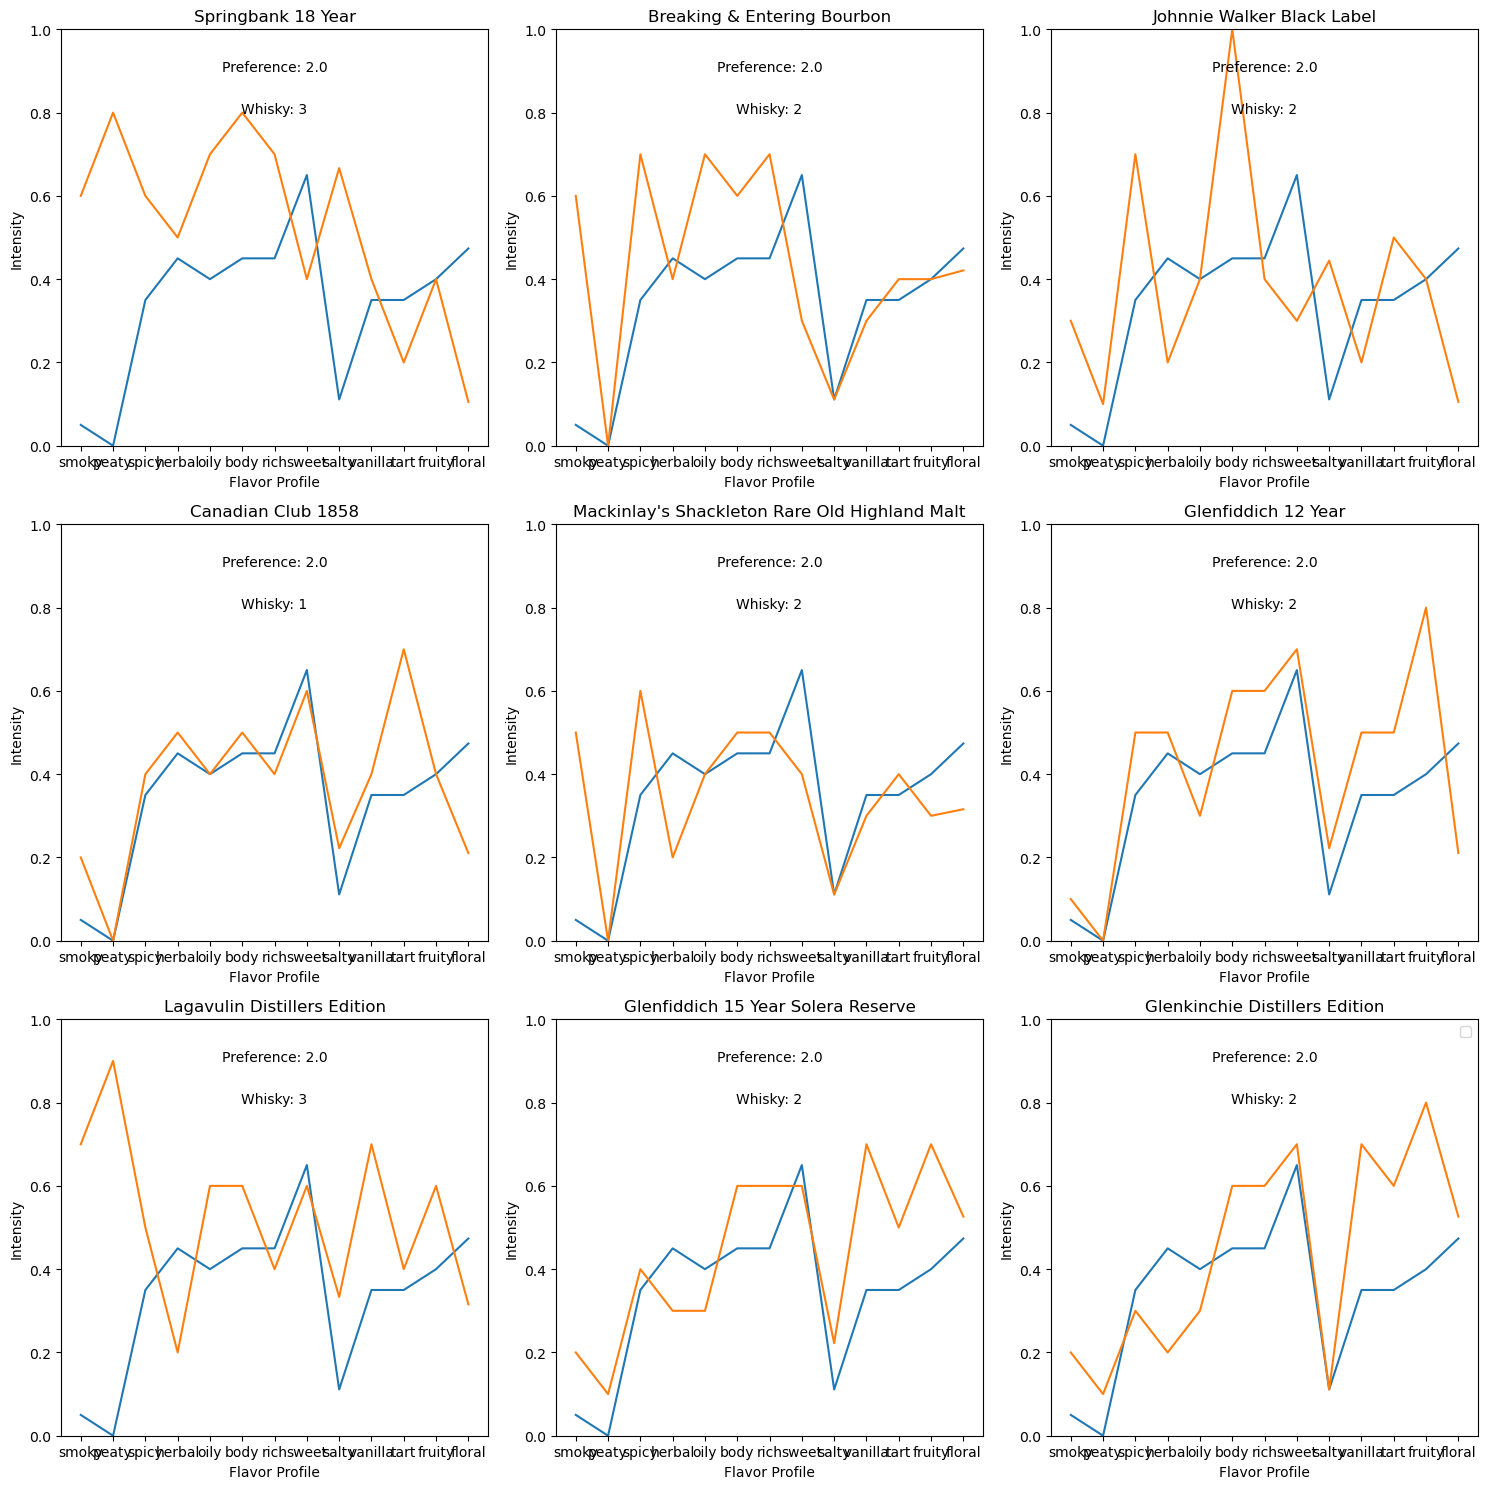

In [130]:
show_comparison_with_my_prefer(preference, u_i_result)

## 전체 rating matrix 집어넣기

In [51]:
train_rating.loc[train_rating.user_id == 94512]

,user_id,whisky_id,rating
820640,94512,1893,7.0


In [52]:
new_ratings = [
    Rating(94512, 2, 10)
]

In [152]:
def make_new_rating_df(ratings):
    return pd.DataFrame([(rating.user_id, rating.whisky_id, rating.rating) for rating in ratings], columns=['user_id', 'whisky_id', 'rating'])


In [60]:
new_rating_df = make_new_rating_df(new_ratings)

In [61]:
new_rating_df = pd.concat([train_rating, new_rating_df], ignore_index=True)

In [62]:
new_rating_df

,user_id,whisky_id,rating
0,54037,724,8.0
1,59687,734,10.0
2,20171,1086,8.0
3,9477,409,10.0
4,15773,3221,8.0
...,...,...,...
686923,17113,1645,6.0
686924,4236,818,8.0
686925,50140,1353,8.0
686926,3891,57,10.0


In [63]:
%time retrain_rating_source = list(zip(new_rating_df['user_id'], new_rating_df['whisky_id'], new_rating_df['rating']))

CPU times: total: 125 ms
Wall time: 169 ms


In [66]:
retrain_rating_source

[(54037, 724, 8.0),
 (59687, 734, 10.0),
 (20171, 1086, 8.0),
 (9477, 409, 10.0),
 (15773, 3221, 8.0),
 (17797, 2380, 7.0),
 (96948, 3024, 6.0),
 (45726, 2889, 9.0),
 (78664, 2657, 4.0),
 (25114, 811, 6.0),
 (2104, 778, 6.0),
 (4804, 2861, 6.0),
 (12226, 1610, 8.0),
 (1319, 2056, 7.0),
 (1319, 1978, 8.0),
 (88245, 2246, 7.0),
 (55471, 2933, 6.0),
 (9296, 911, 10.0),
 (28552, 1369, 8.0),
 (17523, 1985, 4.0),
 (26872, 148, 9.0),
 (26562, 2657, 6.0),
 (23456, 98, 8.0),
 (73927, 2248, 8.0),
 (23913, 2665, 6.0),
 (14591, 411, 6.0),
 (48536, 585, 10.0),
 (102405, 2798, 6.0),
 (1366, 2477, 7.0),
 (1138, 1790, 7.0),
 (42903, 2862, 10.0),
 (6346, 1993, 6.0),
 (1854, 610, 10.0),
 (19246, 1360, 6.0),
 (32208, 3224, 7.0),
 (13243, 2231, 7.0),
 (23263, 818, 10.0),
 (21956, 580, 6.0),
 (27318, 157, 8.0),
 (13406, 93, 7.0),
 (23089, 811, 4.0),
 (67008, 1679, 8.0),
 (21026, 2489, 6.0),
 (8710, 1475, 6.0),
 (4979, 1062, 6.0),
 (110785, 2666, 9.0),
 (6116, 2861, 6.0),
 (43488, 2436, 7.0),
 (2392, 1797, 

In [67]:
retrain_interactions, retrain_weights = origin_dataset.build_interactions(retrain_rating_source)

### fit_partial - rating 정보 전체 전달
---
1. rating만 전달 - 불가능
2. meta 전부 전달 - epoch 당 한 40초 소요

In [ ]:
origin

In [81]:
origin_model.get_user_representations()[0].shape

(119530,)

In [82]:
origin_model.get_user_representations()[1].shape

(119530, 60)

In [83]:
origin_model.get_user_representations()[1]

array([[-0.0004123 , -0.00024451, -0.00151986, ...,  0.00043932,
        -0.00190593, -0.00049039],
       [-0.00451883, -0.01473652, -0.00544267, ...,  0.00967947,
        -0.0029174 ,  0.01097822],
       [ 0.01803982,  0.02722739,  0.00564818, ..., -0.01295746,
         0.00567877, -0.0041647 ],
       ...,
       [ 0.0704419 ,  0.05770337,  0.05465598, ..., -0.05274142,
         0.01732843,  0.09607335],
       [ 0.11295412,  0.03820278,  0.07031108, ..., -0.0661025 ,
         0.01535279,  0.10355736],
       [ 0.09294231,  0.02995651,  0.03288188, ..., -0.06524145,
        -0.09047411,  0.14592879]], dtype=float32)

In [94]:
(modified_model2.get_user_representations()[1] == origin_model.get_user_representations()[1])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.25      , 0.85      ,
        0.5263158 ],
       [0.        , 0.        , 1.        , ..., 0.5       , 0.7       ,
        0.21052632],
       ...,
       [0.        , 0.        , 0.        , ..., 0.2       , 0.3       ,
        0.10526316],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.3       ,
        0.10526316]], dtype=float32)

In [71]:
modified_model2 = origin_model.fit_partial(interactions=retrain_interactions, sample_weight=retrain_weights, user_features=user_meta, item_features=item_meta, epochs=2, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [01:26<00:00, 43.06s/it]


In [123]:
u_i_scores = modified_model2.predict(user_ids=94512, item_ids=item_features.whisky_id.unique(), user_features=my_meta, item_features=item_meta)
u_i_scores

array([-93.68261 , -92.92446 , -92.653534, ..., -93.571144, -93.73662 ,
       -93.4712  ], dtype=float32)

In [124]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


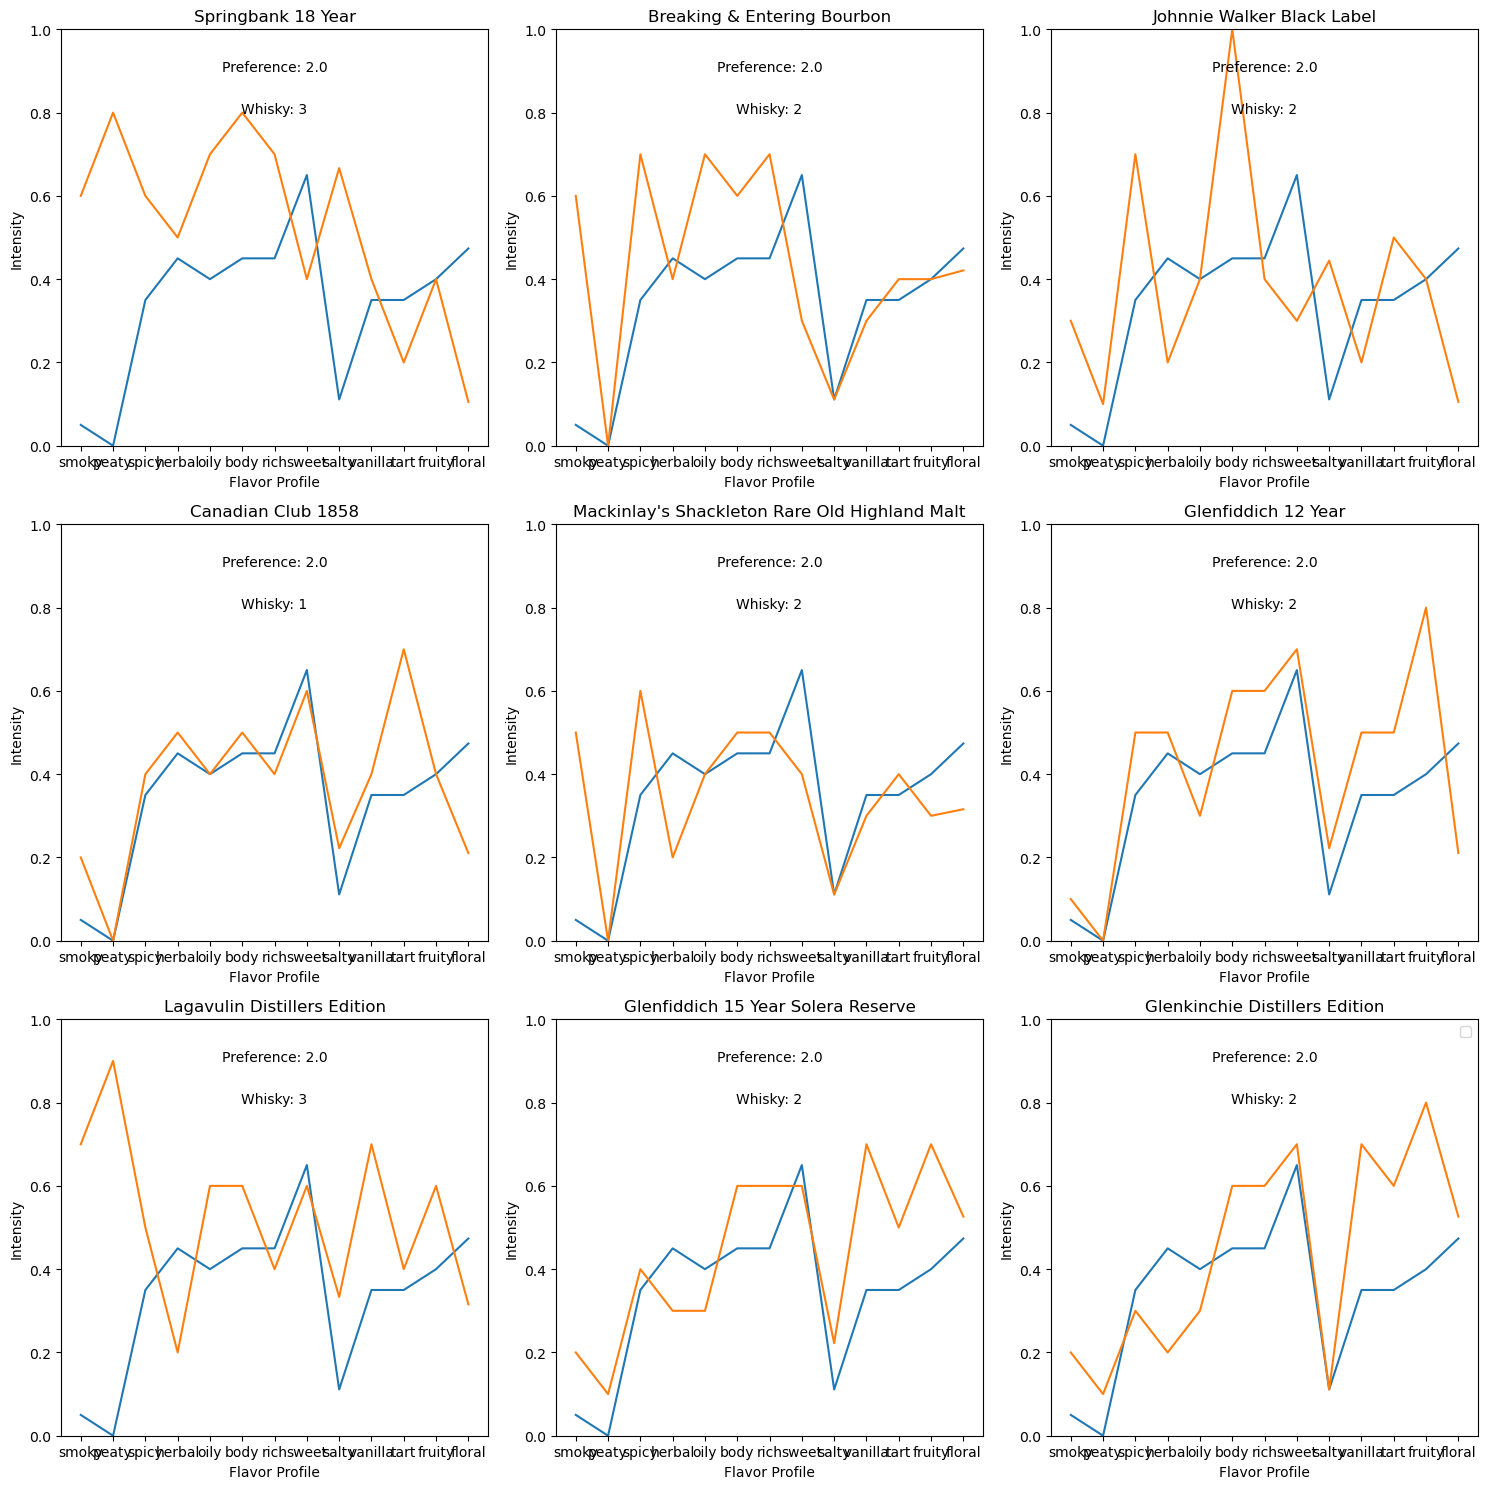

In [116]:
show_comparison_with_my_prefer(preference, u_i_result)

In [101]:
%time test_precision = precision_at_k(modified_model2, test_interactions, user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_recall = recall_at_k(modified_model2, test_interactions,  user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_auc = auc_score(modified_model2, test_interactions, user_features=user_meta, item_features=item_meta).mean()
%time test_rep = reciprocal_rank(modified_model2, test_interactions=test_interactions, user_features=user_meta, item_features=item_meta).mean()


print("Train precision: %.8f" % test_precision)
print("Test precision: %.8f" % test_recall)
print("Test AUC Score : %.8f" % test_auc)
print("Test MRR : %.8f" % test_rep)

CPU times: total: 38 s
Wall time: 1min 42s
CPU times: total: 37 s
Wall time: 1min 41s
CPU times: total: 37.3 s
Wall time: 1min 41s
CPU times: total: 41.1 s
Wall time: 1min 41s
Train precision: 0.03820956
Test precision: 0.15819974
Test AUC Score : 0.92643601
Test MRR : 0.13757378


## retrain rating - 전달된 rating만 전달
---
- 거의 바로 fit 가능

In [131]:
new_ratings

[Rating(user_id=94512, whisky_id=2, rating=10)]

In [132]:
new_rating_df = make_new_rating_df(new_ratings)

In [134]:
%time retrain_rating_source = list(zip(new_rating_df['user_id'], new_rating_df['whisky_id'], new_rating_df['rating']))

CPU times: total: 0 ns
Wall time: 0 ns


In [135]:
new_inter, new_wei = origin_dataset.build_interactions(retrain_rating_source)

In [163]:
%time modified_model1 = origin_model.fit_partial(interactions=new_inter, sample_weight=new_wei, user_features=user_meta, item_features=item_meta, epochs =2, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.92it/s]

CPU times: total: 15.6 ms
Wall time: 48.5 ms


In [138]:
%time test_precision = precision_at_k(modified_model1, test_interactions, user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_recall = recall_at_k(modified_model1, test_interactions,  user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_auc = auc_score(modified_model1, test_interactions, user_features=user_meta, item_features=item_meta).mean()
%time test_rep = reciprocal_rank(modified_model1, test_interactions=test_interactions, user_features=user_meta, item_features=item_meta).mean()


print("Train precision: %.8f" % test_precision)
print("Test precision: %.8f" % test_recall)
print("Test AUC Score : %.8f" % test_auc)
print("Test MRR : %.8f" % test_rep)

CPU times: total: 43.8 s
Wall time: 1min 34s
CPU times: total: 44.8 s
Wall time: 1min 34s
CPU times: total: 45.4 s
Wall time: 1min 36s
CPU times: total: 44 s
Wall time: 1min 36s
Train precision: 0.03822776
Test precision: 0.15836908
Test AUC Score : 0.92643756
Test MRR : 0.13761154


In [139]:
u_i_scores = modified_model1.predict(user_ids=94512, item_ids=item_features.whisky_id.unique(), user_features=my_meta, item_features=item_meta)
u_i_scores

array([-93.69018 , -92.918144, -92.63478 , ..., -93.57561 , -93.74473 ,
       -93.477516], dtype=float32)

In [140]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

[610, 1369, 2679, 3350, 2242, 2255, 95, 2243, 2477]

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]

[610, 1369, 2679, 3350, 2242, 2255, 95, 2243, 2477]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


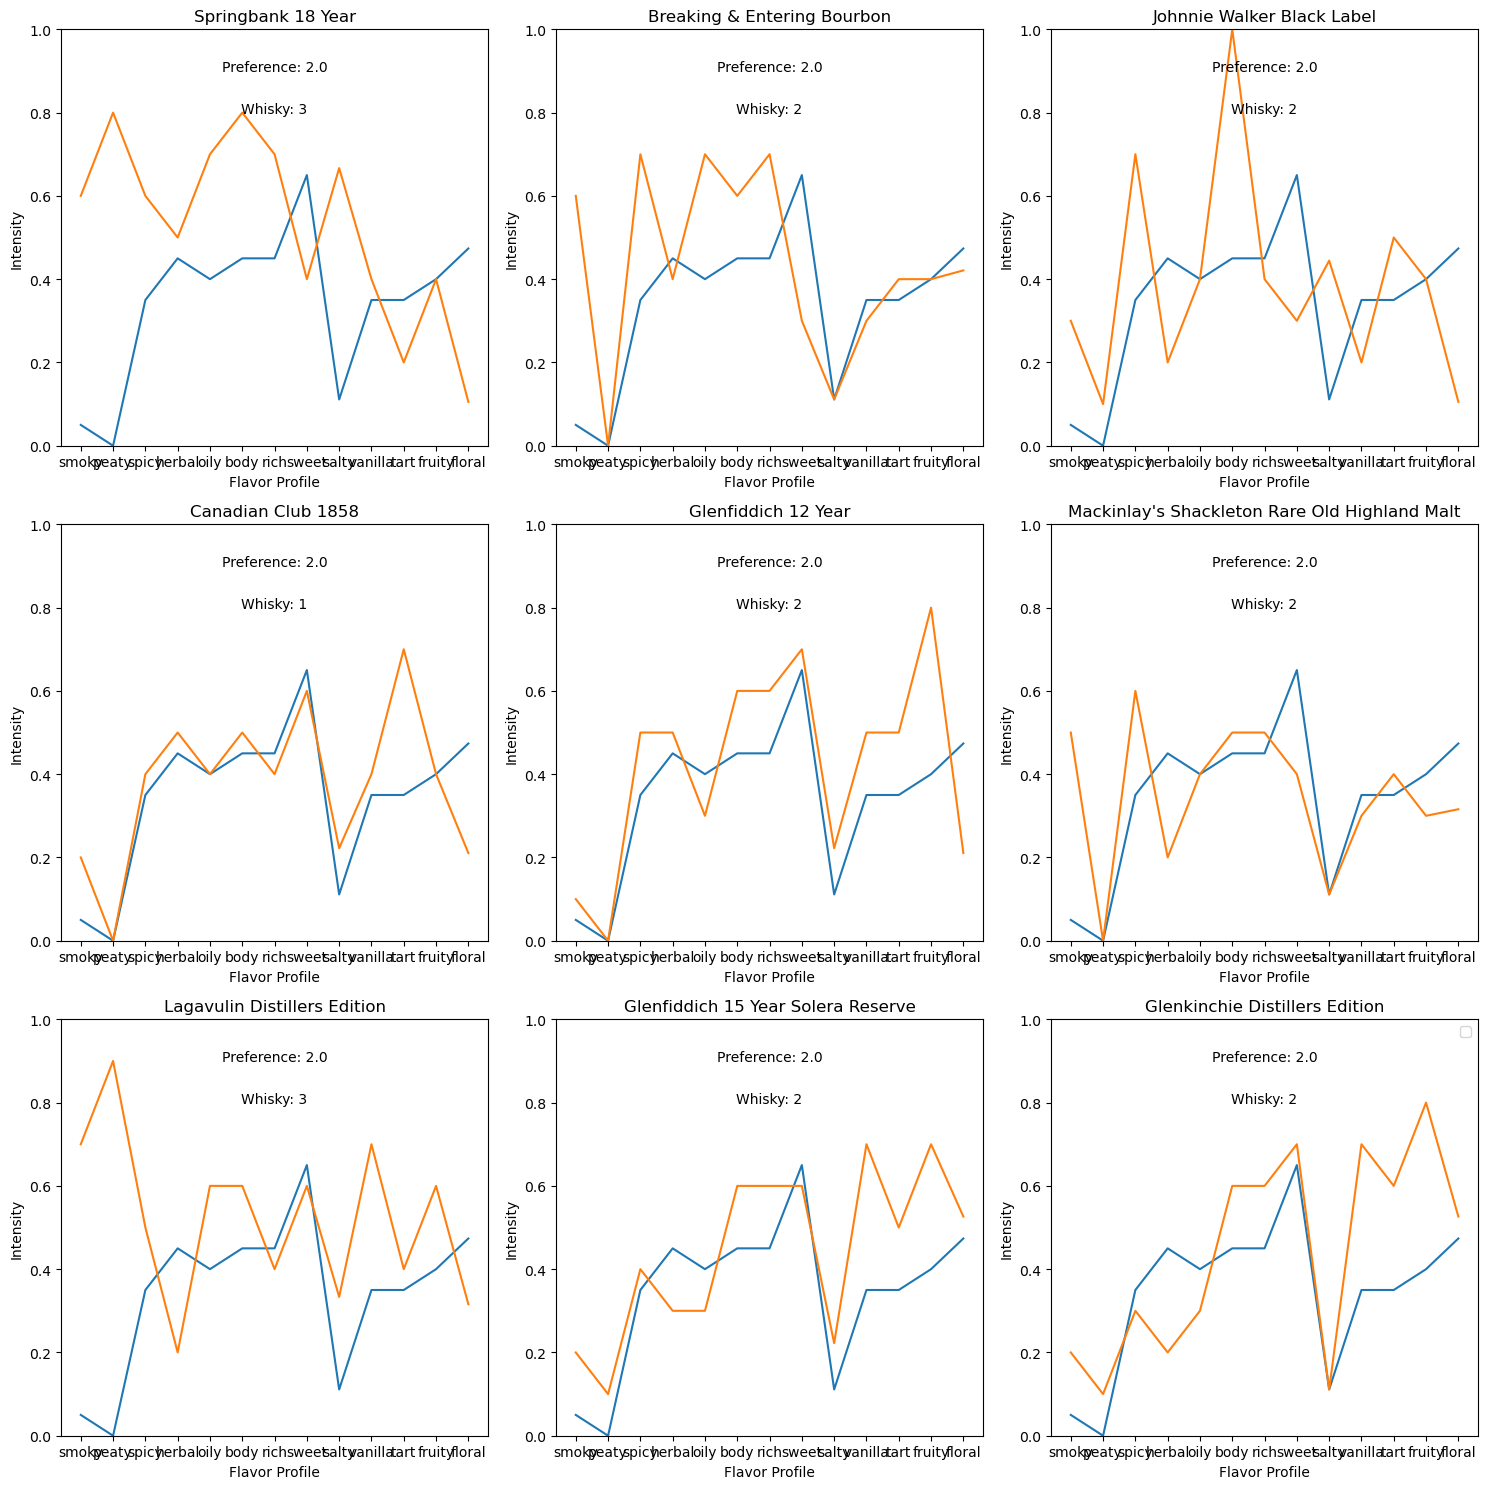

In [141]:
show_comparison_with_my_prefer(preference, u_i_result)

## then, 같은 사용자의 여러 선호도를 추가로 넣어보고 테스트 해보자

In [153]:
ratings = [
    Rating(94512, 1564, 1),
    Rating(94512, 4, 10),
    Rating(94512, 412, 8),
    Rating(94512, 666, 5),
    Rating(94512, 3534, 7),
    Rating(94512, 3300, 6),
    Rating(94512, 9, 5)
]

In [154]:
ratings

[Rating(user_id=94512, whisky_id=1564, rating=1),
 Rating(user_id=94512, whisky_id=4, rating=10),
 Rating(user_id=94512, whisky_id=412, rating=8),
 Rating(user_id=94512, whisky_id=666, rating=5),
 Rating(user_id=94512, whisky_id=3534, rating=7),
 Rating(user_id=94512, whisky_id=3300, rating=6),
 Rating(user_id=94512, whisky_id=9, rating=5)]

In [155]:
new_ratings = make_new_rating_df(ratings)
new_ratings

,user_id,whisky_id,rating
0,94512,1564,1
1,94512,4,10
2,94512,412,8
3,94512,666,5
4,94512,3534,7
5,94512,3300,6
6,94512,9,5


In [156]:
%time retrain_rating_source = list(zip(new_ratings['user_id'], new_ratings['whisky_id'], new_ratings['rating']))

CPU times: total: 0 ns
Wall time: 0 ns


In [157]:
retrain_inter, retrain_wei = origin_dataset.build_interactions(retrain_rating_source)

In [158]:
modified_model3 = origin_model.fit_partial(interactions=retrain_inter, sample_weight=retrain_wei, user_features=user_meta, item_features=item_meta, epochs=2, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 57.10it/s]


In [159]:
u_i_scores = modified_model3.predict(user_ids=94512, item_ids=item_features.whisky_id.unique(), user_features=my_meta, item_features=item_meta)
u_i_scores

array([-93.72397 , -92.939926, -92.65357 , ..., -93.60525 , -93.672775,
       -93.51024 ], dtype=float32)

In [160]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

[610, 2679, 1369, 3350, 2242, 95, 2255, 2243, 98]

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]

[610, 2679, 1369, 3350, 2242, 95, 2255, 2243, 98]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


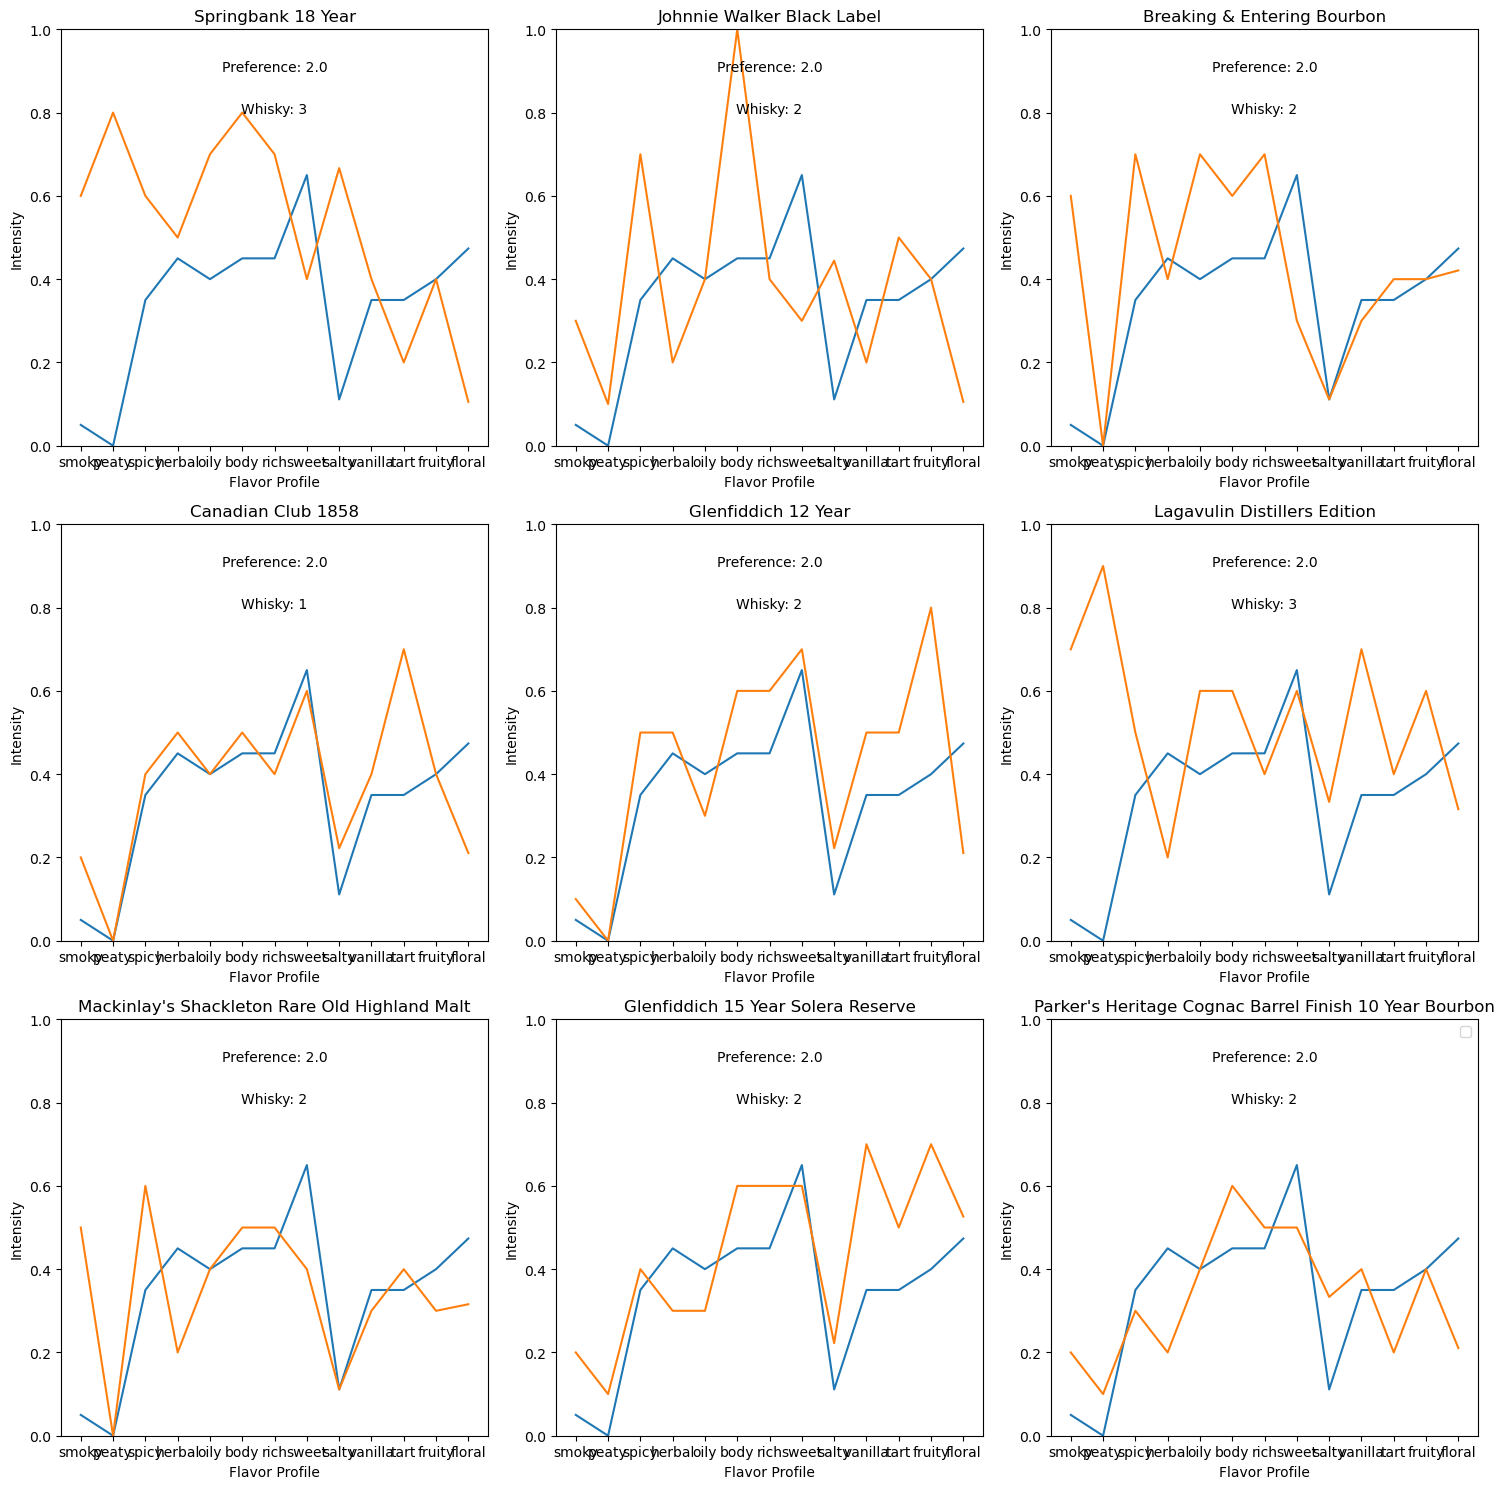

In [161]:
show_comparison_with_my_prefer(preference, u_i_result)

In [162]:
%time test_precision = precision_at_k(modified_model3, test_interactions, user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_recall = recall_at_k(modified_model3, test_interactions,  user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_auc = auc_score(modified_model3, test_interactions, user_features=user_meta, item_features=item_meta).mean()
%time test_rep = reciprocal_rank(modified_model3, test_interactions=test_interactions, user_features=user_meta, item_features=item_meta).mean()


print("Train precision: %.8f" % test_precision)
print("Test precision: %.8f" % test_recall)
print("Test AUC Score : %.8f" % test_auc)
print("Test MRR : %.8f" % test_rep)

CPU times: total: 42.2 s
Wall time: 1min 32s
CPU times: total: 42.1 s
Wall time: 1min 29s
CPU times: total: 43.8 s
Wall time: 1min 30s
CPU times: total: 44.6 s
Wall time: 1min 31s
Train precision: 0.03823139
Test precision: 0.15836789
Test AUC Score : 0.92643738
Test MRR : 0.13762745
